# Creating drop down menus to visualize four different type of risk data in the United States or in West Virginia

The use of this notebook assumes you have performed the following:
* Followed the directions in the "How to access data on AWS.docx" document for "Processing Data Via Amazon S3 Buckets".
* Recorded your AWS access credentials in the `credentials.json` file
* To be fully functional, you must download the data sets for fire, flood, heat, and wind into your S3 bucket from First Street.

* The following packages need to be installed into your Python environment:
    * pandas
    * folium
    * matplotlib
    * mapclassify
    * branca
    * ipywidgets
    * matplotlib
    * geopandas
    * seaborn
    * json
    * fsspec
    * s3fs

---

In [1]:
# Configure the following variables to match your environment
auxilliaryDataDirectory = "..\\Climate Risk data\\Auxiliary Data\\"

# This is your AWS S3 bucket name
s3_URI_prefix = "s3://justindemo123"


`createDisasterRiskWidget()` - Generates a GUI component for selecting different disaster risk options.

In [2]:
import ipywidgets as widgets

def createDisasterRiskWidget():
    # Formatting settings for drop-down menus
    style = {'description_width': '120px'}
    layout = widgets.Layout(width='325px')

    # Create drop-down menu for disaster type
    return widgets.Dropdown(options=['fire', 'flood', 'heat', 'wind'], 
                            description='Disaster:', style=style, layout=layout)


This function, `getRegionRiskWidget()`, serves a similar purpose to the previous function. It creates a GUI component for selecting different regions to be analyzed.

In [3]:
def getRegionRiskWidget():
    # Formatting settings for drop-down menus
    style = {'description_width': '120px'}
    layout = widgets.Layout(width='325px')

    return widgets.Dropdown(options=['United States', 'West Virginia'],
                            description='Region:', style=style, layout=layout)



`risk_data(disaster_type, region)` - Retrieves and processes risk data for a selected disaster type and region.  

Handles data retrieval, processing, and geo-processing to analyze risk factors associated with the chosen disaster.  
Returns processed data, including FIPS code, region name, average risk, and geometry.

In [4]:
import pandas as pd
import geopandas as gpd
import json

def risk_data(disaster_type, region):
    if region == 'United States':
        reg = "state"
    else:
        reg = "county"

    # Determine the version of the data to use based on the disaster type
    match disaster_type:
        case "fire":
            version = "v2.0"
        case "flood":
            version = "v3.0"
        case "heat":
            version = "v1.2"
        case _:
            version = "v1.1"

    # Construct the URI to the data in the S3 bucket
    S3_URI = f"{s3_URI_prefix}/{disaster_type}/{version}/summary/fsf_{disaster_type}_{reg}_summary.csv"

    # Retrieve credentials from a local file
    with open('credentials.json') as f:
        creds = json.load(f)

    # Read the data from the S3 bucket
    risk_data = pd.read_csv(
        S3_URI,
        storage_options={
            "key": creds['key'],
            "secret": creds['secret']
        })

    # Calculate the average risk per region
    risk_data['average_risk'] = 0
    for i in range(1, 11):
        risk_data['average_risk'] += risk_data[f'count_{disaster_type}factor{i}'] * i
        
    # These lines normalize the average risk per property and standardize 
    # the formatting of FIPS codes in the data frame.
    risk_data['average_risk'] /= risk_data['count_property']
    risk_data.fips = risk_data['fips'].astype(str).str.zfill(2)

    if region == 'United States':
        # EPSG (European Petroleum Survey Group) is a standard for defining coordinate systems.
        df_geo_US = gpd.read_file(f"{auxilliaryDataDirectory}cb_2018_us_state_500k.shp").to_crs("EPSG:4326")
        df_geo_US = df_geo_US.rename(columns={'GEOID': 'fips'})
        
        result_US = pd.merge(risk_data, df_geo_US, on='fips')
        final_data_US = result_US[['fips', 'name', 'average_risk', 'geometry']]
        return final_data_US
    else:
        df_geo_WV = gpd.read_file(f"{auxilliaryDataDirectory}WV_County_Boundaries.geojson").to_crs("EPSG:4326")
        df_geo_WV = df_geo_WV.rename(columns={'FIPS': 'fips'})

        # converting fips codes to strings is done for WV (and not the US) as part of the data cleaning process.
        df_geo_WV.fips = df_geo_WV['fips'].astype(str)

        result_WV = pd.merge(risk_data, df_geo_WV, on='fips')
        final_data_WV = result_WV[['fips', 'namelsad', 'average_risk', 'geometry']].rename(columns={'namelsad': 'name'})
        return final_data_WV


`top5HighRiskPlot(disaster_type, region)` - Generates a bar plot displaying the top five at risk regions with the highest risk factor for the chosen disaster type.

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

def top5HighRiskPlot(disaster_type, region):
    # make the data global so that it doesn't have to be reloaded
    global data

    # fetch the data
    data = risk_data(disaster_type, region)

    sorted_data = data.sort_values(by='average_risk', ascending=False)

    plt.figure(figsize=(8, 5))
    if region == 'United States':
        plt.title(f'Top five states with highest {disaster_type} risk')
        if (disaster_type == 'heat' or disaster_type == 'fire'):
            palette = sns.color_palette("OrRd", as_cmap=True)
        else:
            palette = sns.color_palette("Blues", as_cmap = True)
    else:
        plt.title(f'Top five counties in WV with highest {disaster_type} risk')
        if (disaster_type == 'heat' or disaster_type == 'fire'):
            palette = sns.color_palette("OrRd", as_cmap=True)
        else:
            palette = sns.color_palette("Blues", as_cmap = True)
        
    ax = sns.barplot(data=sorted_data.head(), x='name', y='average_risk', hue="average_risk", legend=False, palette = palette)
    ax.set(xlabel=None)
    plt.tight_layout()
    plt.show()

`riskDistributionMap(disaster_type)` - Generates an interactive map showing the distribution of risk associated with a specific disaster.

In [6]:
def riskDistributionMap(disaster_type):
    # Choose a color map based on the disaster type
    if (disaster_type == 'heat' or disaster_type == 'fire'):
        colorMap = 'OrRd'
    else:
        colorMap = 'Blues'

    # Create a GeoDataFrame from the data using the EPSG:4326 coordinate reference system
    crs = {'init': 'EPSG:4326'}
    geo_df = gpd.GeoDataFrame(data, crs=crs, geometry=data.geometry)

    # Return an interactive map widget
    return geo_df.explore(
        column="average_risk",
        tooltip="name",
        popup=True,
        tiles="CartoDB positron",
        cmap=colorMap,
        style_kwds=dict(color="black"),
        legend_kwds=dict(caption=f"{disaster_type} Risk")
    )

In [7]:
# Display the disaster risk options to the user
riskChoicesWidget = createDisasterRiskWidget()
riskChoicesWidget

Dropdown(description='Disaster:', layout=Layout(width='325px'), options=('fire', 'flood', 'heat', 'wind'), sty…

In [8]:
# Display the user's choice.
#   Note: The embedded '\033[1m' and '\033[0m' are for bolding the displayed text, and are not functional or required.
print(f"Risk Selection: \033[1m{riskChoicesWidget.value}\033[0m")

Risk Selection: fire


In [9]:
# Display the region options to the user
regionChoiceWidget = getRegionRiskWidget()
regionChoiceWidget

Dropdown(description='Region:', layout=Layout(width='325px'), options=('United States', 'West Virginia'), styl…

In [10]:
print(f"Region Selection: \033[1m{regionChoiceWidget.value}\033[0m")

Region Selection: United States


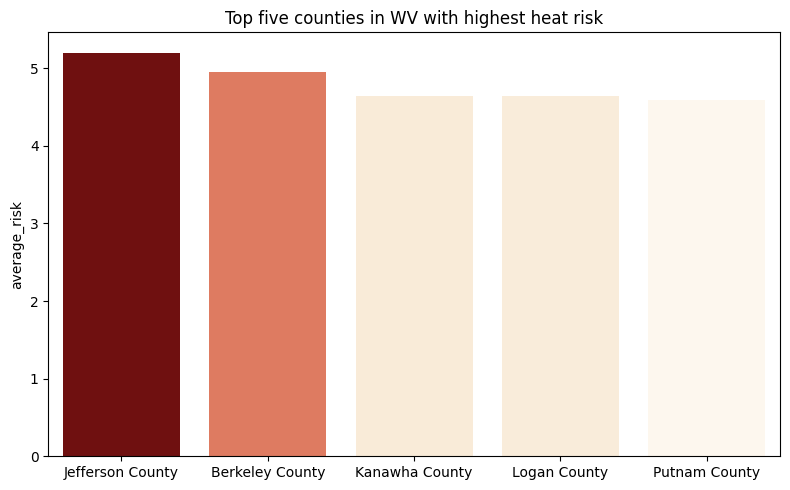

In [17]:
# Display the risk plot
top5HighRiskPlot(riskChoicesWidget.value, regionChoiceWidget.value)

In [18]:
# Display the risk distribution map
riskDistributionMap(riskChoicesWidget.value)